## Random Model Editing: How does performance change when the model is randomly changed rather than using an image to guide the edit?

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [2]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from parse_config import ConfigParser
import datasets.datasets as module_data

import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer.editor import Editor

from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json, ensure_files, ensure_dir
from utils.model_utils import prepare_device
from utils.results_to_csv import store_csv
from utils.edit_utils import prepare_edit_data #, get_target_weights
from utils.knn_utils import knn, analyze_knn, load_and_analyze_knn
from utils.df_utils import load_and_preprocess_csv, summary_histogram
from utils.visualizations import histogram

from edit_knn import main as edit

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

### Outline

1. given a path of keys and values
2. perform an edit for each key and value
    a. save the weight difference in a list
3. after all edits, stack the tensors and take the mean and std

In [3]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
# Define constants, paths
config_path = 'configs/copies/edit_experiments/cinic10_imagenet-random_edit.json'
class_list_path = 'metadata/cinic-10/class_names.txt'

analyze_in_edit = False
sort_type = 'softmax'

In [10]:
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')
paths_timestamp = '0126_161209'


In [11]:
# Load config file
config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

# n_select = 1500

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])

In [12]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset_args"])

# Create validation data loader
val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_image_paths = read_lists(config_dict['covariance_dataset']['images'])
covariance_labels = read_lists(config_dict['covariance_dataset']['labels'])

covariance_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=covariance_image_paths,
        labels=covariance_labels,
        **dataset_args
    ),
    **data_loader_args
)

### Calculate the mean and STD of weight differences

In [1]:
def edit_return_weight_diff(config,
         val_paths_data_loader=None,
         covariance_data_loader=None,
         do_analyze_knn=False):

    logger = config.get_logger('train')
    assert config.config['method'] == 'edit', "Invalid method '{}'. Must be 'edit'".format(config.config['method'])
    # K = config.config['editor']['K']  # for KNN

    # Store variables for if we want to perform knn analysis here
    if 'perform_analysis' in config.config['editor']:
        do_analyze_knn = config.config['editor']['perform_analysis']
    if do_analyze_knn:
        try:
            class_list_path = config.config['class_list_path']
        except:
            raise ValueError("class_list_path not in config file. Aborting")
        try:
            class_list = read_lists(class_list_path)
        except:
            raise ValueError("Unable to read file at {}. Aborting".format(class_list_path))

    save_dir = str(config.save_dir)

    # General arguments for data loaders
    dataset_args = config.config['dataset_args']
    data_loader_args = config.config['data_loader']['args']

    # build model architecture, then print to console
    config.config['arch'].update()
    layernum = config.config['layernum']
    model = config.init_obj('arch', module_arch, layernum=layernum)


    logger.info("Created {} model with {} trainable parameters".format(config.config['arch']['type'], model.get_n_params()))
    if model.get_checkpoint_path() != "":
        logger.info("Restored weights from {}".format(model.get_checkpoint_path()))
    else:
        logger.info("Training from scratch.")

    # Provide dataloader to perform KNN and metric calculation
    # if val_paths_data_loader is None:
    #     val_image_paths = read_lists(config.config['dataset_paths']['valid_images'])
    #     val_labels = read_lists(config.config['dataset_paths']['valid_labels'])
    #     val_paths_data_loader = torch.utils.data.DataLoader(
    #         module_data.CINIC10Dataset(
    #             data_dir="",
    #             image_paths=val_image_paths,
    #             labels=val_labels,
    #             return_paths=True,
    #             **dataset_args
    #         ),
    #         **data_loader_args
    #     )
    #     logger.info("Created validation data loader for metric and KNN calculations")
    # else:
    #     logger.info("Using passed in data loader for validation.")

    # Prepare for (multi-device) GPU training
    device, device_ids = prepare_device(config['n_gpu'])
    model = model.to(device)
    if len(device_ids) > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    model.eval()  # model should always be in eval() for editing

    # Get function handles for loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]

    # Prepare data for edit
    key_path = config.config['editor']['key_image_path']
    # key_image_paths = read_lists(key_image_path)
    value_path = config.config['editor']['value_image_path']
    # value_image_paths = read_lists(value_image_path)
    mask_path = config.config['editor']['mask_path']
    if mask_path == "":
        mask_path = None

    logger.info("Key images: {}".format(key_path))
    logger.info("Value images: {}".format(value_path))
    logger.info("Masks: {}".format(mask_path))

    edit_data = prepare_edit_data(
        key_image_path=key_path,
        value_image_path=value_path,
        mask_path=mask_path,
        image_size=(32, 32))
    logger.info("Prepared data for editing")

    # Set up editor
    editor_args = config.config['editor']['args']
    editor_args['arch'] = config.config['arch']['args']['type']

    editor = Editor(**editor_args)

    if covariance_data_loader is None:
        if 'covariance_dataset' in config.config and 'images' in config.config['covariance_dataset']:
            # Always use the dummy val_data_loader for covariance calculation
            covariance_image_paths = read_lists(config.config['covariance_dataset']['images'])
            covariance_labels = read_lists(config.config['covariance_dataset']['labels'])

            covariance_data_loader = torch.utils.data.DataLoader(
                module_data.CINIC10Dataset(
                    data_dir="",
                    image_paths=covariance_image_paths,
                    labels=covariance_labels,
                    return_paths=False,
                    **dataset_args
                ),
                **data_loader_args
            )
            val_data_name = config.config['covariance_dataset']['name']

            logger.info("Created dataloader for covariance matrix from {}".format(config.config['covariance_dataset']['images']))
        else:  # Use identity matrix
            covariance_data_loader = None
            val_data_name = "identity"
            logger.info("No data loader for covariance matrix. Will use identity matrix")
    else:
        val_data_name = config.config['covariance_dataset']['name']
        logger.info("Using passed in covariance data loader.")

    # Create path for caching directory based on
    #   (1) validation data dir
    #   (2) context model -- architecture, layer number

    model_arch = model.get_type()

    cache_dir = os.path.join('cache', val_data_name, "{}-{}".format(model_arch, layernum))
    logger.info("Looking for covariance matrix weights in {}".format(cache_dir))
    # Obtain original model weights
    original_weights = model.get_target_weights()
    # Perform edit
    editor.edit(
        edit_data=edit_data,
        model=model,
        val_data_loader=covariance_data_loader,
        cache_dir=cache_dir)
    
    # Get edited weights
    edited_weights = model.get_target_weights()
    
    # Calculate weight difference
    weight_diff = edited_weights - original_weights


    logger.info("All metrics and KNN results can be found in {}".format(save_dir))
    
    return weight_diff


In [2]:
weight_differences = []
for target_class_idx, target_class_name in enumerate(class_list):
    # if target_class_idx != 1: 
    #     continue
    # Create save directories and logging paths
    save_root = config_dict['trainer']['save_dir']
    save_trials_path = os.path.join(save_root, config_dict['name'], '{}_{}'.format(target_class_name, n_select), timestamp, 'trial_paths.txt')
    progress_report_path = os.path.join(save_root, config_dict['name'], '{}_{}'.format(target_class_name, n_select), timestamp, 'progress_report.txt')
    informal_log("Current target class: {}".format(target_class_name), progress_report_path)
    
    
    if os.path.exists(save_trials_path):
        print("Path {} already exists. Overwriting.".format(save_trials_path))
    else:
        if os.path.exists(progress_report_path):
            os.remove(progress_report_path)
        print("Printing progress reports to {}".format(progress_report_path))
        informal_log("Saving path to directories for each trial to {}".format(save_trials_path), progress_report_path)
    
    # Obtain paths for keys and values
    paths_dir = os.path.join('paths', 'edits', 'semantics', '{}_{}'.format(target_class_name, n_select), paths_timestamp)
    key_image_paths_path = os.path.join(paths_dir, 'key_images_{}.txt'.format(sort_type))
    key_image_paths = read_lists(key_image_paths_path)

    value_image_paths_path = os.path.join(paths_dir, 'value_images_{}.txt'.format(sort_type))
    value_image_paths = read_lists(value_image_paths_path)
    n_trials = len(value_image_paths)
    assert len(key_image_paths) == n_trials

    non_existent_key_paths = ensure_files(key_image_paths)
    non_existent_value_paths = ensure_files(value_image_paths)
    
    if len(non_existent_key_paths) > 0:
        raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))

    if len(non_existent_value_paths) > 0:
        raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))
        
    informal_log("Key image paths stored at {}".format(key_image_paths_path), progress_report_path)
    informal_log("Value image paths stored at {}".format(value_image_paths_path), progress_report_path)
    
    # Create list to store weight differences
    # weight_differences = []
    
    # Run edit for each key and value pair
    for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
        if idx == 5:
            break
        split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
        class_name = os.path.basename(os.path.dirname(key_path))
        file_name = os.path.basename(key_path).split(".")[0]
        key_image_id = "{}-{}-{}".format(class_name, split, file_name)
        # Print Progress
        informal_log("({}) Starting Trial {}/{}...".format(datetime.now().strftime(r'%m%d_%H%M%S'), idx + 1, n_trials), progress_report_path)

        # Create run id 
        value_image_id = os.path.splitext(os.path.basename(value_path))[0]
        run_id = os.path.join('{}_{}'.format(target_class_name, n_select), timestamp, 'results', key_image_id, value_image_id)
        informal_log("Current run_id: {}".format(run_id), progress_report_path)

        # Read config file as json and make updates to key and value paths
        config_dict = read_json(config_path)
        config_dict['editor'].update({
            'key_image_path': key_path,
            'value_image_path': value_path
        })

        # Create config object
        config = ConfigParser(config_dict, run_id=run_id)

        # Log the current trial path
        informal_log(os.path.dirname(config.save_dir), save_trials_path)

        informal_log("Calling edit()...", progress_report_path)

        weight_differences.append(edit_return_weight_diff(
            config=config,
            val_paths_data_loader=val_paths_data_loader,
            covariance_data_loader=covariance_data_loader,
            do_analyze_knn=analyze_in_edit))

        # Print progress
        informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
                    progress_report_path)



NameError: name 'class_list' is not defined

In [ ]:
# Create histogram of weights
diff_array = torch.stack(weight_differences, dim=0)
data = torch.flatten(diff_array)


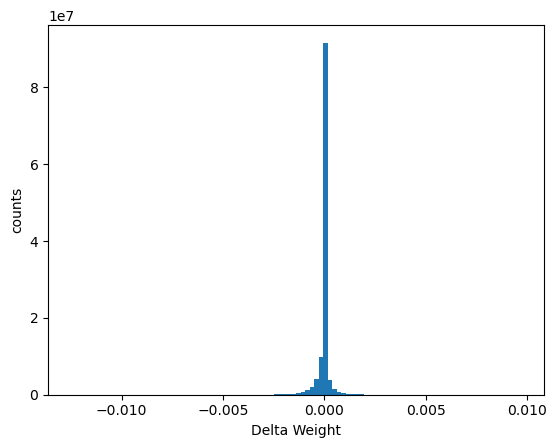

In [65]:
histogram(
    data=data.detach().cpu().numpy(),
    n_bins=100,
    xlabel='Delta Weight',
    ylabel='counts')

### Perform Random Model Editing

In [13]:
# fix random seeds for reproducibility
# SEED = 123
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(SEED)

# Set variables
n_trials = 1500
save_root = config_dict['trainer']['save_dir']
save_trials_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')

In [14]:
# Check if path to trial already exists
if os.path.exists(save_trials_path):
        print("Path {} already exists. Overwriting.".format(save_trials_path))
else:
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Printing progress reports to {}".format(progress_report_path))
    informal_log("Saving path to directories for each trial to {}".format(save_trials_path), progress_report_path)

Printing progress reports to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/trial_paths.txt


In [ ]:
weight_differences = []
# for target_class_idx, target_class_name in enumerate(class_list):
for iter_idx in range(n_trials):
    informal_log("Iter {}/{}".format(iter_idx+1, n_trials), progress_report_path)
    
    run_id = os.path.join(timestamp, 'results', 'iter_{}'.format(iter_idx))
    informal_log("Current run_id: {}".format(run_id), progress_report_path)

    # Read config file as json and make updates to key and value paths
    config_dict = read_json(config_path)
    # config_dict['editor'].update({
    #     'key_image_path': key_path,
    #     'value_image_path': value_path
    # })

    # Create config object
    config = ConfigParser(config_dict, run_id=run_id)

    # Log the current trial path
    informal_log(os.path.dirname(config.save_dir), save_trials_path)

    informal_log("Calling edit()...", progress_report_path)

    edit(
        config=config,
        val_paths_data_loader=val_paths_data_loader,
        covariance_data_loader=covariance_data_loader,
        do_analyze_knn=analyze_in_edit)

    # Print progress
    informal_log("Finished trial {}/{}. Results saved to {}".format(iter_idx + 1, n_trials, os.path.dirname(config.save_dir)),
                progress_report_path)



### Analyze the results

In [25]:
# Before calling this, call python src/utils/results_to_csv.py with the trial_paths_path

csv_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
save_visualizations_dir = os.path.join(os.path.dirname(save_trials_path), 'graphs')
ensure_dir(save_visualizations)
df = load_and_preprocess_csv(
    csv_path=csv_path,
    drop_duplicates=['ID'])
print("{} rows in data frame".format(len(df)))

NameError: name 'ensure_dir' is not defined

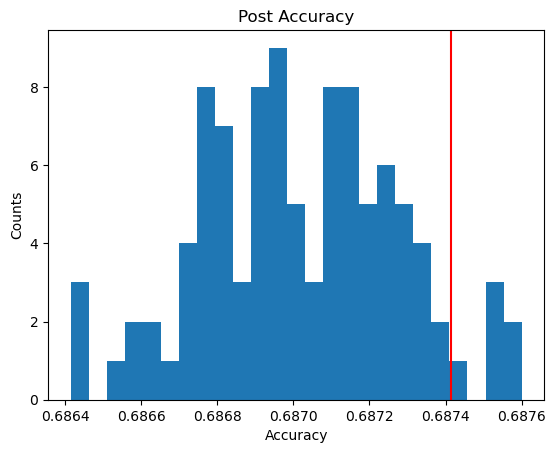

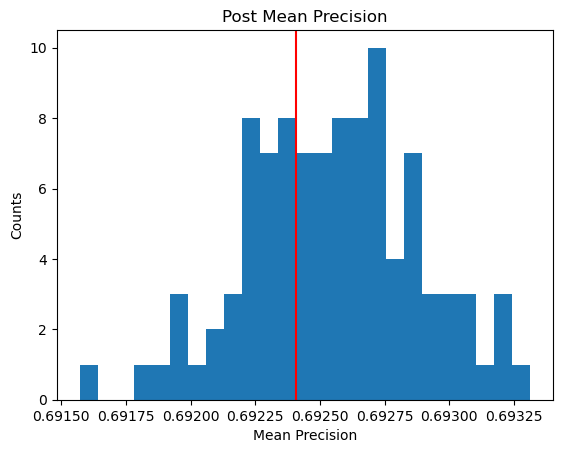

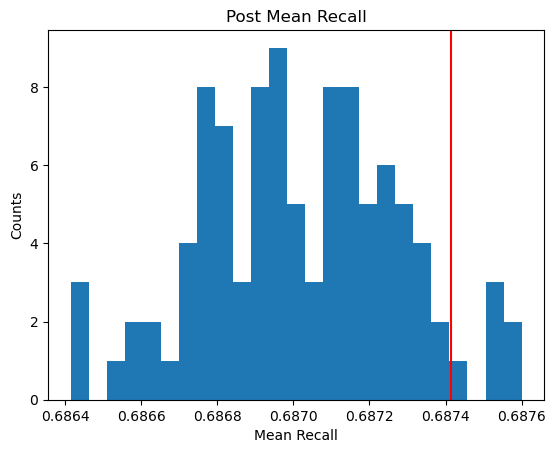

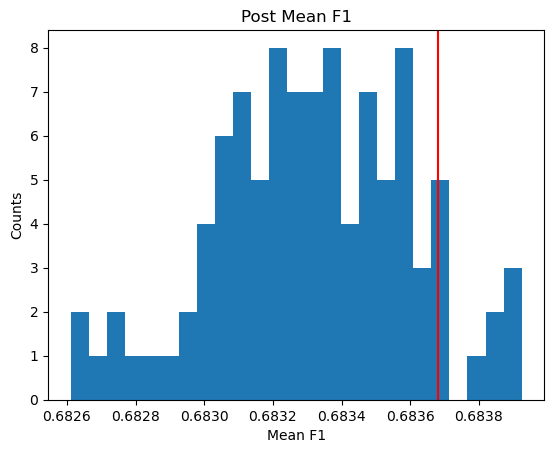

In [27]:
metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1']]

summary_histogram(
    df_=df,
    metrics=metrics,
    n_bins=25)
    